# Interpretando los modelos, conectando con humanos

## SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la instalación y carga de los módulos necesarios:

In [1]:
!pip install shap
!pip install umap
!pip install umap-learn
!pip install lightgbm

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/f5/fc/e81722d6bec4fcba46e46ef895eddaeab0027ac71e78fc35ef351fac5fe4/shap-0.43.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/81/d7/d2537d51efb692d0c411e64267ba349e7668d40f5bc73cefe78ccd650dcd/scipy-1.11.3-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.4 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.4/60.4 kB 1.1 MB/s eta 0:00:00
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/f1/7d/2e562207176a5dcdad513085670674bb11ffaf37e1393eacb6d7fb502481/scikit_learn-1.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhosted.org/packages/e8/1c/5d65ac922a4f9a6f90a10207b818e22e4d48a782af6574

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer


Cargamos el dataset. Vamos a trabajar con el primer conjunto de datos pero usted deberá utilizar un dataset ampliado y más refinado. Preparamos y separamos las clases y 

In [2]:
#ds_train = pd.read_csv("/home/aleb/dmeyf23/datasets/competencia_01.csv")
ds_train = pd.read_csv("C:/Users/epugnalo/OneDrive - Telefonica/Documents/Data Mining UBA/2C - DM en Economica y Finanzas/datasets/competencia_01.csv")
ds_train = ds_train[ds_train.foto_mes==202103]
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.


Y armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos los de los **datasets** los targets.

In [3]:
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)


Y hacemos un modelo **LGBM**. En este punto, usted agregue los mejores parámetros que haya encontrado.

In [4]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 500,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


Hasta ahora, las herramientas para saber a que feature le daba importancia un modelo eran básicas. No era mucho más que un **feature importance**

In [5]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
7,mrentabilidad_annual,255
50,cpayroll_trx,237
21,mcuentas_saldo,157
10,mpasivos_margen,156
71,mcomisiones_mantenimiento,152
...,...,...
62,cpagomiscuentas,0
61,mpagodeservicios,0
60,cpagodeservicios,0
59,mttarjeta_master_debitos_automaticos,0


Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [6]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [8]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)
#df

0.2569559094421972


,118657,7
thomebanking,0.00,0.033119
mcuenta_corriente,-139.59,0.029853
Visa_mpagominimo,2815.20,0.017775
chomebanking_transacciones,0.00,0.016068
tcallcenter,0.00,0.007473
...,...,...
cdescubierto_preacordado,0.00,-0.246521
mprestamos_personales,0.00,-0.256114
mcuentas_saldo,-2159.75,-0.270304
cpayroll_trx,0.00,-0.338765


In [9]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][cliente_idx,:], ds_bajas.iloc[cliente_idx,:])

En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [10]:
shap_bajas.abs().mean().sort_values(ascending=False)


ctrx_quarter                            0.840985
cpayroll_trx                            0.374244
mpasivos_margen                         0.166882
mprestamos_personales                   0.155896
mcuentas_saldo                          0.134080
                                          ...   
cpagomiscuentas                         0.000000
mpagodeservicios                        0.000000
cpagodeservicios                        0.000000
mttarjeta_master_debitos_automaticos    0.000000
mforex_buy                              0.000000
Length: 153, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

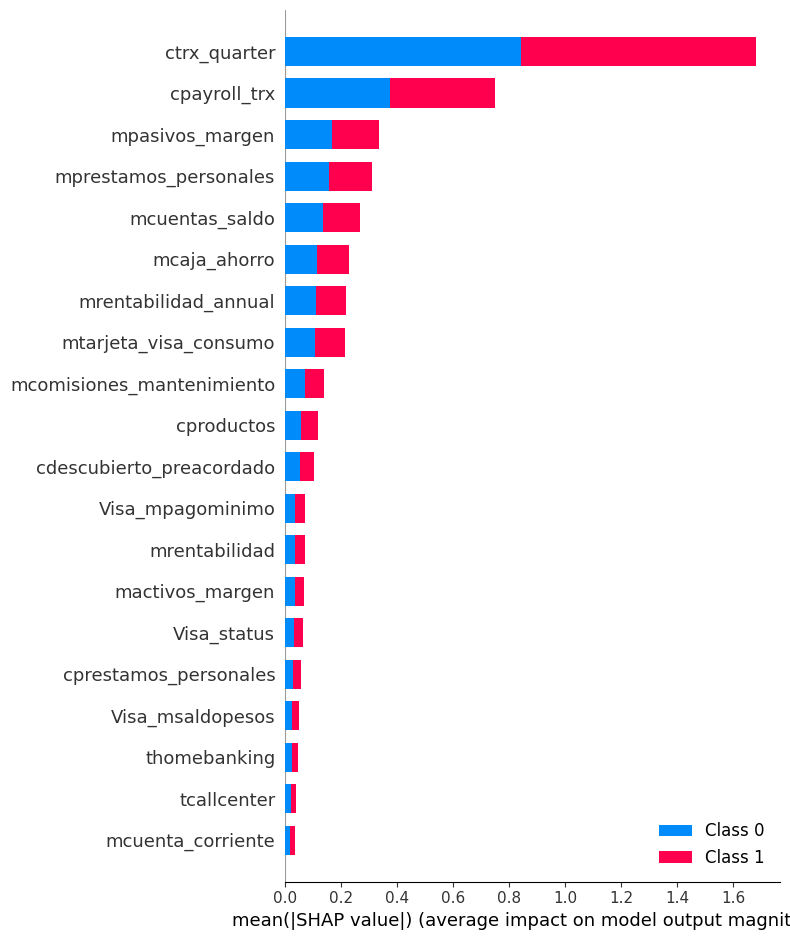

In [11]:
shap.summary_plot(shap_values, ds_bajas)

Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

## ¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

<Figure size 640x480 with 0 Axes>

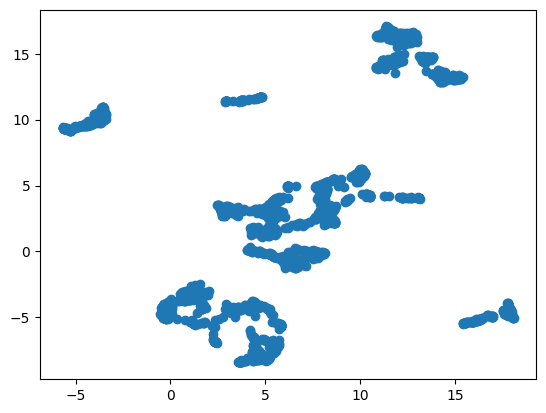

<Figure size 640x480 with 0 Axes>

In [12]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=14
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])
plt.figure()

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

(array([464., 290., 203., 176., 156., 135., 105.,  71.,  70.,  73.,  47.,
         36.,  40.,  20.,  15.,  36.,  11.,  11.,   9.,  10.,   9.,   1.,
          9.,   1.,   5.,   0.,   2.,   1.,   2.,   4.]),
 array([0.00498115, 0.02289187, 0.04080259, 0.05871331, 0.07662403,
        0.09453475, 0.11244546, 0.13035618, 0.1482669 , 0.16617762,
        0.18408834, 0.20199906, 0.21990978, 0.2378205 , 0.25573122,
        0.27364193, 0.29155265, 0.30946337, 0.32737409, 0.34528481,
        0.36319553, 0.38110625, 0.39901697, 0.41692769, 0.4348384 ,
        0.45274912, 0.47065984, 0.48857056, 0.50648128, 0.524392  ,
        0.54230272]),
 <BarContainer object of 30 artists>)

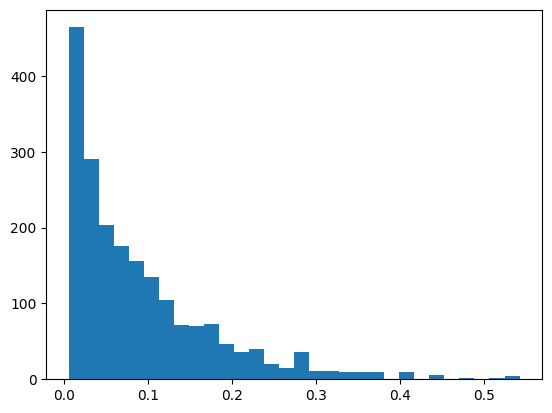

In [13]:
plt.hist(p_bajas,bins=30)

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

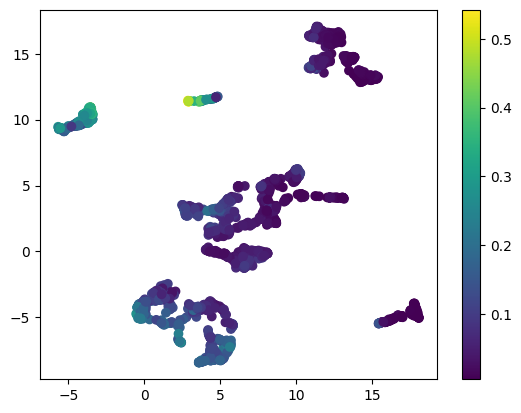

In [14]:
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()

[('0', 381), ('1', 584), ('2', 62), ('3', 145), ('4', 195), ('5', 529), ('6', 116)]


<Axes: >

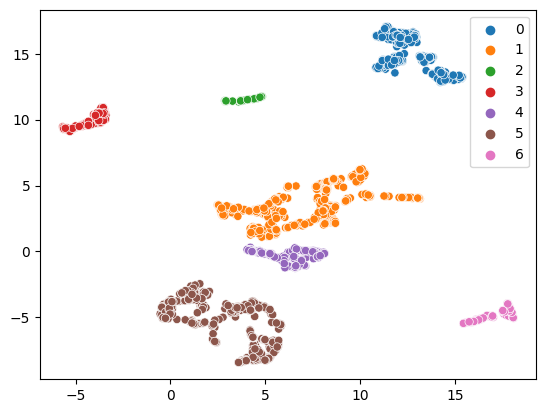

In [46]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

hdb = DBSCAN(eps=0.9) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

labels = [str(x) for x in y.labels_]
keys, values = np.unique(labels, return_counts=True)
print(list(zip(keys, values)))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=labels)


Comparamos 2 clusters para ver si cambian sus variables importantes

In [347]:
# Mostrar importancia de variables por cluster:
cluster_por_ordenar = '1'
filas_a_mostrar =20

mean_shap_values =shap_bajas.groupby(labels).mean().transpose()
mean_shap_values.sort_values(by=cluster_por_ordenar,ascending=False, key=abs)[0:filas_a_mostrar]

,0,1,2,3,4,5,6
ctrx_quarter,0.141,-0.752,-1.501,-1.494,-0.862,-1.240,-0.358
cpayroll_trx,-0.504,-0.357,-0.419,-0.338,-0.347,-0.311,0.388
mpasivos_margen,-0.137,-0.123,-0.141,-0.164,-0.177,-0.174,-0.029
mtarjeta_visa_consumo,-0.057,-0.089,-0.152,-0.121,-0.051,-0.107,-0.024
mcomisiones_mantenimiento,-0.019,-0.062,-0.029,-0.033,0.040,-0.068,-0.032
mcaja_ahorro,0.001,-0.057,-0.143,-0.201,-0.108,-0.130,-0.005
mprestamos_personales,-0.040,-0.054,-0.198,-0.271,-0.135,-0.221,-0.033
mrentabilidad_annual,-0.051,-0.051,0.011,-0.018,-0.033,-0.039,-0.018
cdescubierto_preacordado,-0.000,-0.036,-0.065,-0.305,0.022,0.025,0.001
cproductos,-0.057,-0.029,-0.099,-0.090,-0.020,-0.046,-0.007


Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

In [128]:
def imprimir_descriptivo(variable):
    describer = ds_bajas.groupby(labels)[variable].describe(include='all')
    describer['#nulos'] = ds_bajas[variable].isnull().groupby(labels).sum()
    describer_gral= ds_train[variable].describe(include='all')
    describer_gral["#nulos"]= ds_train[variable].isnull().sum()
   
    return(pd.concat([describer.transpose(), describer_gral.transpose()], axis=1))

In [314]:
def imprimir_perf_entero(variable, lista_clusters):
    
    value_counts_cluster = ds_bajas.groupby(labels)[variable].value_counts(normalize=True).reset_index().rename(columns={'level_0':'cluster_n', 'ctrx_quarter':'value', 'proportion':'frequency'})
    mask = value_counts_cluster['cluster_n'].isin(lista_clusters)
    value_counts_cluster = value_counts_cluster[mask]

    value_counts_gral = ds_train[variable].value_counts(normalize=True).reset_index()
    value_counts_gral.columns = ['value', 'frequency']
    value_counts_gral['cluster_n']='todo'
    value_counts_gral = value_counts_gral[['cluster_n', 'value', 'frequency']]

    data = pd.concat([value_counts_gral, value_counts_cluster])
    sns.barplot(data, y='frequency', x='value', hue='cluster_n', palette='Set2')

In [318]:
#IMPRIMIR DESCRIPTIVO
pd.set_option('display.float_format', lambda x: '%.3f' % x)
imprimir_descriptivo("mtransferencias_recibidas")

,0,1,2,3,4,5,6,mtransferencias_recibidas
count,381.000,584.000,62.000,145.000,195.000,529.000,116.000,163324.000
mean,84124.187,13720.564,4104.806,426.598,3682.249,2183.356,72676.322,125004.422
std,231042.707,31750.920,11059.290,1957.895,11804.330,19630.988,167130.699,717898.766
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4809.300,0.000,0.000,0.000,0.000,0.000,0.000,469.200
50%,33899.700,2517.660,0.000,0.000,0.000,0.000,17595.000,36361.235
75%,79237.390,15512.925,967.725,0.000,1759.500,0.000,83089.455,114173.938
max,2739189.600,475065.000,57540.340,17431.950,113781.000,411136.500,1211155.870,119454225.960
#nulos,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


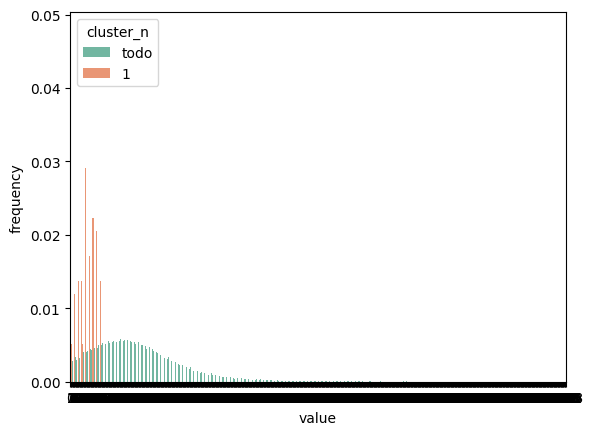

In [315]:
## IMPRIMIR PERFILAO ENTERO
variable='ctrx_quarter'    
lista_clusters = ['1']
imprimir_perf_entero(variable, lista_clusters)


# IMPRMIR PERFILADO CONTINUO
pd.set_option('display.float_format', lambda x: '%.3f' % x)
imprimir_descriptivo("mcuentas_saldo")


Text(0.5, 1.0, 'Overlapping')

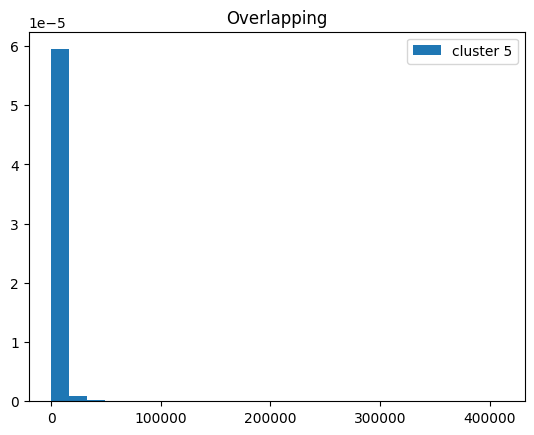

In [350]:

#plt.hist(ds_bajas.loc[:]["mtransferencias_recibidas"], label='all', density=True, bins=10)
plt.hist(ds_bajas.loc[y.labels_ == 5]["mtransferencias_recibidas"], label='cluster 5', density=True, bins=25)

plt.legend(loc='upper right')
plt.title('Overlapping')
